## Model Building For Stock Prediction

**Historical Volatility** or **Realized Volatility**:
It is measure of actual price volatility observed in financial markets over a specific time period. Realized volatility is used to assess the actual market risk or uncertainty experienced by investors and traders. It's a key metric for risk management, option pricing, and portfolio optimization.

**Implied volatility** :
It is a measure of market participants' expectations regarding the future price volatility of a financial instrument, such as a stock, index, currency pair, or commodity.

**Realized volatility often exhibits volatility clustering, meaning that periods of high volatility tend to be followed by other periods of high volatility, and periods of low volatility tend to be followed by other periods of low volatility. This phenomenon is captured by models like ARCH and GARCH. We will be using Realized Volalility for the Prediction of Series.**

#### Note:
- Volatility doesn't tell you if prices are going up or down. Instead, it measures how scattered or spread out those price changes are. Imagine two investments: one with low volatility and one with high volatility. Even if they both make the same average return, the high volatility one will have bigger swings in prices over time. It's like looking at the range of possible outcomes without caring about the direction.

- Although 

## Objective

### The purpose of this project is to forecast one variable of the above equation: the realized volatility based on historical/past data using time series analysis.

In [32]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import yfinance as yf
import datetime
from scipy import stats
import warnings
from statsmodels.tsa.stattools import adfuller,kpss
warnings.filterwarnings('ignore')

sns.set(style="darkgrid")
%matplotlib inline
plt.rcParams['font.size'] = 14
plt.rcParams['figure.figsize'] = (16, 8)

In [4]:
stock_symbol = "^NSEI"  
stock_data = yf.download(stock_symbol, start="2008-1-1", end="2023-5-1")

[*********************100%***********************]  1 of 1 completed


In [5]:
df = stock_data.copy()

<b>**Types of Stationarity**</b>

- Let us understand the different types of stationarities and how to interpret the results of the above tests.

<b>Strict Stationary</b>: A strict stationary series satisfies the mathematical definition of a stationary process. For a strict stationary series, the mean, variance and covariance are not the function of time. The aim is to convert a non-stationary series into a strict stationary series for making predictions.A Gaussian time series implies stationarity is strict stationarity.

- Time Series which doesnot imply Gaussian Time Series are called **Weak Stationarity**.Time series models, such as **ARIMA (AutoRegressive Integrated Moving Average) and SARIMA (Seasonal ARIMA)**, assume weak stationarity or stationarity

<b>Trend Stationary</b>: A series that has no unit root but exhibits a trend is referred to as a trend stationary series. Once the trend is removed, the resulting series will be strict stationary. The KPSS test classifies a series as stationary on the absence of unit root. This means that the series can be strict stationary or trend stationary.

<b>Difference Stationary</b>: A time series that can be made strict stationary by differencing falls under difference stationary. ADF test is also known as a difference stationarity test.


- Case 1: Both tests conclude that the given series is stationary – The series is stationary
- Case 2: Both tests conclude that the given series is non-stationary – The series is non-stationary
- Case 3: ADF concludes non-stationary, and KPSS concludes stationary – The series is trend stationary. To make the series strictly stationary, the trend needs to be removed in this case. Then the detrended series is checked for stationarity.
- Case 4: ADF concludes stationary, and KPSS concludes non-stationary – The series is difference stationary. Differencing is to be used to make series stationary. Then the differenced series is checked for stationarity.

In [6]:
def ADFTest(series):
    result = adfuller(series, autolag='AIC')
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    if result[1] < 0.05 :
        print ("Reject Ho - Time Series is Stationary")
    else:
        print ("Failed to Reject Ho - Time Series is Non-Stationary")
def kpss_test(series, **kw):    
    statistic, p_value, n_lags, critical_values = kpss(series, **kw)
    # Format Output
    print(f'KPSS Statistic: {statistic}')
    print(f'p-value: {p_value}')
    print(f'Result: The series is {"not " if p_value < 0.05 else ""}stationary')


In [7]:
ADFTest(df['Close'])
print('*'*64)
kpss_test(df['Close'])

ADF Statistic: 0.48581838718914305
p-value: 0.9844356237898235
Failed to Reject Ho - Time Series is Non-Stationary
****************************************************************
KPSS Statistic: 8.55624690554685
p-value: 0.01
Result: The series is not stationary


- As Both Results are Non Stationary which is case 2.
- The Series is Non Stationary
#### Even after transforming non-stationary data into stationary data, there is no guarantee that the residual variance or volatility will remain constant. This assumption of constant residual variance is one of the key assumptions of ARIMA and SARIMA models. In other words, achieving stationarity in the data doesn't automatically ensure that the variability of the residuals will be consistent throughout the time series, which can impact the validity of these models.

In [14]:
df.head()

,Open,High,Low,Close,Adj Close,Volume,log_return
Date,,,,,,,
2008-01-01,6136.750000,6165.350098,6109.850098,6144.350098,6144.350098,0,NaN
2008-01-02,6144.700195,6197.000000,6060.850098,6179.399902,6179.399902,0,13.895495
2008-01-03,6184.250000,6230.149902,6126.399902,6178.549805,6178.549805,0,NaN
2008-01-04,6179.100098,6300.049805,6179.100098,6274.299805,6274.299805,0,12.911315
2008-01-07,6271.000000,6289.799805,6193.350098,6279.100098,6279.100098,0,15.920522


**Log Return**
- *Logarithmic Returns = ln(Present Value / Previous Value)*
- It helps eliminate non-stationary properties of time series data, and makes it more stable. On top of that, it reduces computational cost

In [255]:
# ARCH models are designed to capture volatility.
# log returns can help achieve stationarity by stabilizing the variance and reducing the influence of trends.

df['Returns'] = 100*df['Close'].pct_change()
log_returns = np.log(df['Close'] / df['Close'].shift(1)).dropna()
squared_log_returns = log_returns ** 2
df.dropna(inplace = True)

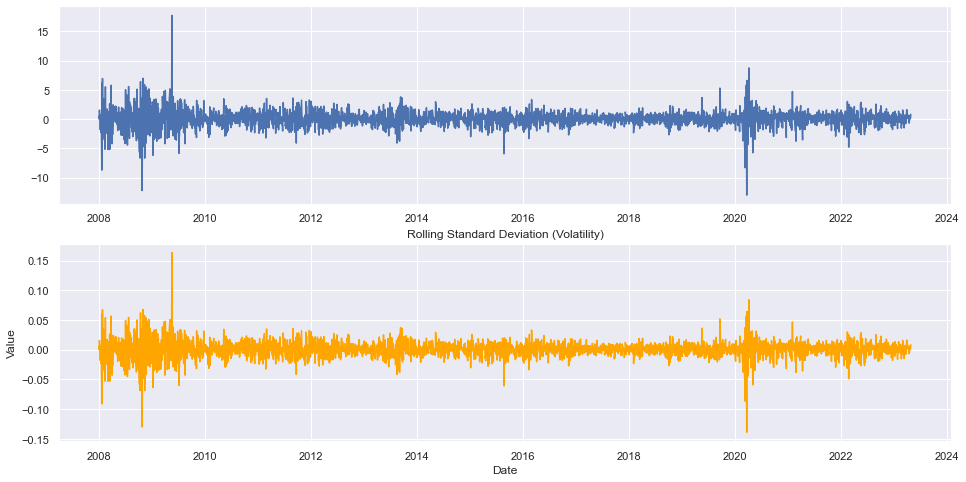

In [152]:
fig,ax = plt.subplots(2,1)
ax[0].plot(df.index, df['Returns'], label='Original Data')
ax[1].plot(df['log_return'], color='orange')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Rolling Standard Deviation (Volatility)')
plt.show()

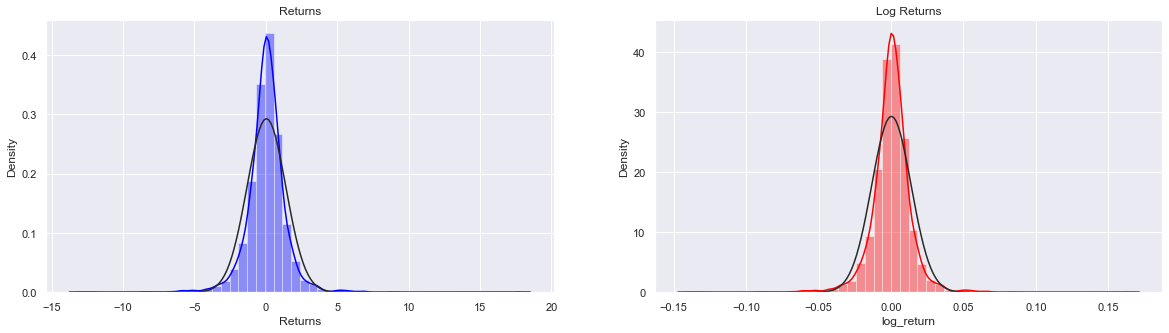

In [154]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20,5))
sns.distplot(df['Returns'], norm_hist=True, fit=stats.norm, color='blue',
             bins=50, ax=ax1)
ax1.set_title('Returns')

sns.distplot(df['log_return'], norm_hist=True, fit=stats.norm, color='red',
             bins=50, ax=ax2)
ax2.set_title('Log Returns')

fig.show()    

- Both Returns and Log Return of the Index prices Lepokruptic Curve
- Positive kurtosis (leptokurtic) - higher peak with thick tails than the standard normal distribution.

This formula calculates the volatility of an asset by taking the square root of the sum of squared deviations of the logarithmic returns from their mean. It is an important concept in finance for assessing risk and understanding the potential price fluctuations of an asset

*Realized_Volatility = √(∑(Rt)^2 )*

In [155]:
# def realized_volatility(log_returns):
#     # As we have already made log(return)
#     mean_log_returns = np.mean(log_returns)
#     print(mean_log_returns)
    
#     squared_diff_sum = np.sum((log_returns - mean_log_returns)**2)
#     N = len(log_returns)
    
#     volatility = np.sqrt(squared_diff_sum / (N - 1))
#     return volatility
    

In [156]:
def realized_volatility(log_returns):
    return np.sqrt(np.sum(log_returns**2))
volt = df['log_return'].apply(realized_volatility)
df['Volatility'] = volt

In [157]:
df.head()

,Open,High,Low,Close,Adj Close,Volume,log_return,Returns,Volatility
Date,,,,,,,,,
2008-01-02,6144.700195,6197.000000,6060.850098,6179.399902,6179.399902,0,0.005688,0.570440,0.005688
2008-01-03,6184.250000,6230.149902,6126.399902,6178.549805,6178.549805,0,-0.000138,-0.013757,0.000138
2008-01-04,6179.100098,6300.049805,6179.100098,6274.299805,6274.299805,0,0.015378,1.549716,0.015378
2008-01-07,6271.000000,6289.799805,6193.350098,6279.100098,6279.100098,0,0.000765,0.076507,0.000765
2008-01-08,6282.450195,6357.100098,6221.600098,6287.850098,6287.850098,0,0.001393,0.139351,0.001393


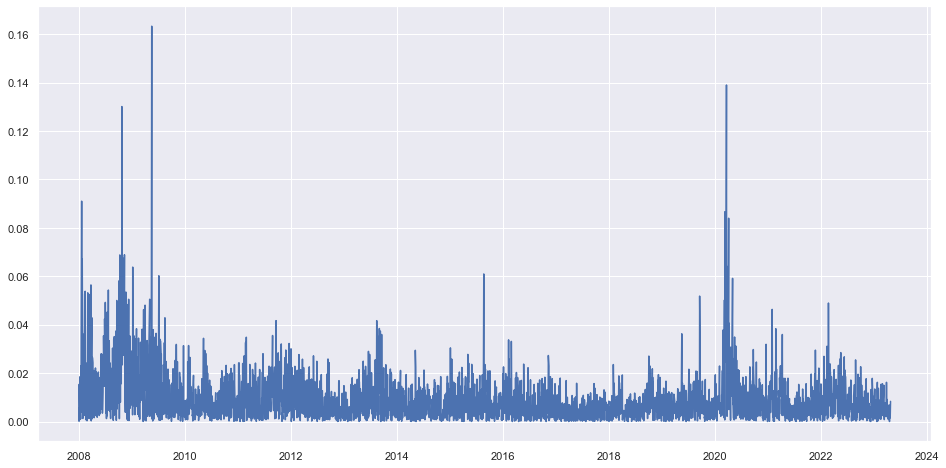

In [158]:
plt.plot(df['Volatility'])

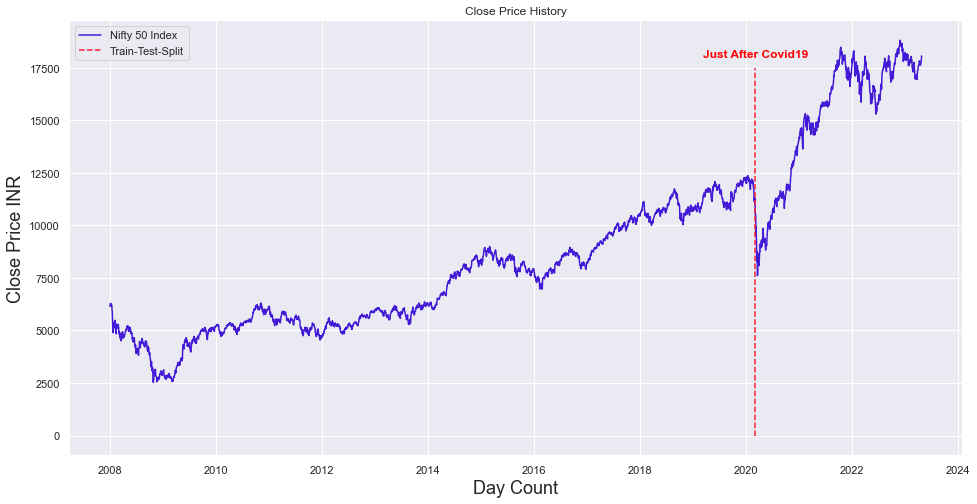

In [159]:
plt.title('Close Price History')
plt.plot(stock_data['Close'], color='#431ad6', label='Nifty 50 Index')
plt.vlines(datetime.date(2020, 3, 9), 0, 17500, linestyles='dashed', label='Train-Test-Split', colors='#f71e33')
plt.text(datetime.date(2020, 3, 9), 18000, "Just After Covid19", color='red', 
         fontsize=12, weight='bold', horizontalalignment='center')
plt.xlabel('Day Count', fontsize=18)
plt.ylabel('Close Price INR', fontsize=18)
plt.legend()
plt.show()

#### Divided the Index Stock into Train and Test after 2020 upto 2023 as on March 2020 the stock market experienced an abrupt drop in response to the impact of the COVID-19 pandemic.So the testing will be interesting as after 2020 most of the test data is in a exponential growth period.


In [258]:
#As seen in Above Chart of Train and Test Split.
# Validation Data is of last n days
n = 20
train_idx = slice(None, '2020-03-09')  # Corrected train_idx slice
test_idx = slice('2020-03-10', None)  # Corrected test_idx slice
val_idx = slice(-n, None)  # Corrected val_idx slice

# Assuming you have a Series named log_returns

# Log Returns Split
train_log_returns = log_returns[train_idx]
test_log_returns = log_returns[test_idx].iloc[:-16]
val_log_returns = log_returns[val_idx]

#For Volatility we will do the same split for the Comparision 
volt_train = df['Volatility'][:'2020-03-09']
volt_test = df['Volatility'].loc['2020-03-10':].iloc[:-16]
volt_val = df['Volatility'].iloc[-n:]

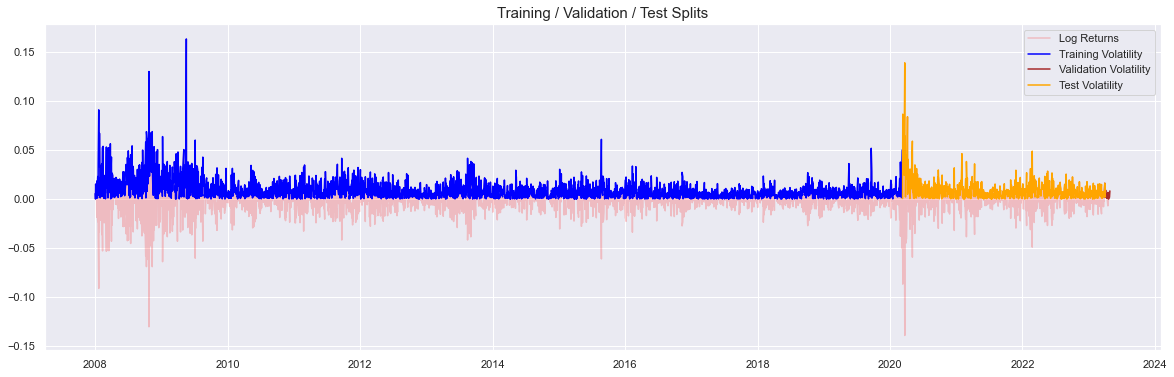

In [206]:
plt.figure(figsize=(20,6))

plt.plot(df['log_return'], color='red', label='Log Returns', alpha=0.2)

plt.plot(vol_train, color='blue', label='Training Volatility')
plt.plot(vol_val, color='brown', label='Validation Volatility')
plt.plot(vol_test, color='orange', label='Test Volatility')

plt.plot()
plt.title('Training / Validation / Test Splits', fontsize=15)
plt.legend()
plt.show();

#### As There is a Volatility Clustering can be Observed in the above Graph So We can Go for ARCH and GARCH Approach

-----------------------------------------------------------------------------------------------------------------------

## ARCH(Autoregressive Conditional  Heteroscedasticity)

- ARCH focuses on modeling the volatility (variance) of the current error (residual) as a function of the past squared errors.
- ARCH(p):
σ²(t) = α₀ + α₁ * ε²(t-1) + α₂ * ε²(t-2) + ... + αₚ * ε²(t-p)

- GARCH(p, q):
σ²(t) = α₀ + α₁ * ε²(t-1) + α₂ * ε²(t-2) + ... + αₚ * ε²(t-p) + β₁ * σ²(t-1) + β₂ * σ²(t-2) + ... + βq * σ²(t-q)

Where:

- σ²(t) is the conditional variance (volatility) at time t.
- ε²(t) is the squared error (residual) at time t.
- α₀ is the constant term (omega).
- α₁, α₂, ..., αₚ are the coefficients of the squared errors at lags (ARCH terms).
- β₁, β₂, ..., βq are the coefficients of the conditional variances at lags (GARCH terms).
- p is the order of the ARCH terms.
- q is the order of the GARCH terms.

- For More Details please refer :
 https://lost-stats.github.io/Time_Series/ARCH_Model.html

In [164]:
from arch import arch_model

In [271]:
arc = arch_model(train_log_returns, vol='ARCH', p=1,
                  mean='Zero', dist='skewstudent')
result = gm_1.fit(disp = 'final')
print()
print(result.summary())

Iteration:      1,   Func. Count:      5,   Neg. LLF: -9033.102518874099
Optimization terminated successfully    (Exit mode 0)
            Current function value: -9033.102520862423
            Iterations: 5
            Function evaluations: 5
            Gradient evaluations: 1

                              Zero Mean - ARCH Model Results                             
Dep. Variable:                             Close   R-squared:                       0.000
Mean Model:                            Zero Mean   Adj. R-squared:                  0.000
Vol Model:                                  ARCH   Log-Likelihood:                9033.10
Distribution:      Standardized Skew Student's t   AIC:                          -18058.2
Method:                       Maximum Likelihood   BIC:                          -18034.2
                                                   No. Observations:                 2974
Date:                           Wed, Aug 23 2023   Df Residuals:                     2974

In [266]:
forecast_horizon = len(test_log_returns)
forecasted_variance = result.forecast(horizon=forecast_horizon)
forecasted_volatility = np.sqrt(forecasted_variance.variance.values)

In [267]:
forecasted_variance.variance.values

array([[           nan,            nan,            nan, ...,
                   nan,            nan,            nan],
       [           nan,            nan,            nan, ...,
                   nan,            nan,            nan],
       [           nan,            nan,            nan, ...,
                   nan,            nan,            nan],
       ...,
       [           nan,            nan,            nan, ...,
                   nan,            nan,            nan],
       [           nan,            nan,            nan, ...,
                   nan,            nan,            nan],
       [1.14515896e+20, 1.14515894e+20, 1.14515893e+20, ...,
        1.14514958e+20, 1.14514957e+20, 1.14514956e+20]])

In [268]:
vol_test.shape

(761,)

In [269]:
forecasted_volatility.shape

(3753, 761)

ValueError: x and y must have same first dimension, but have shapes (761,) and (3753, 761)

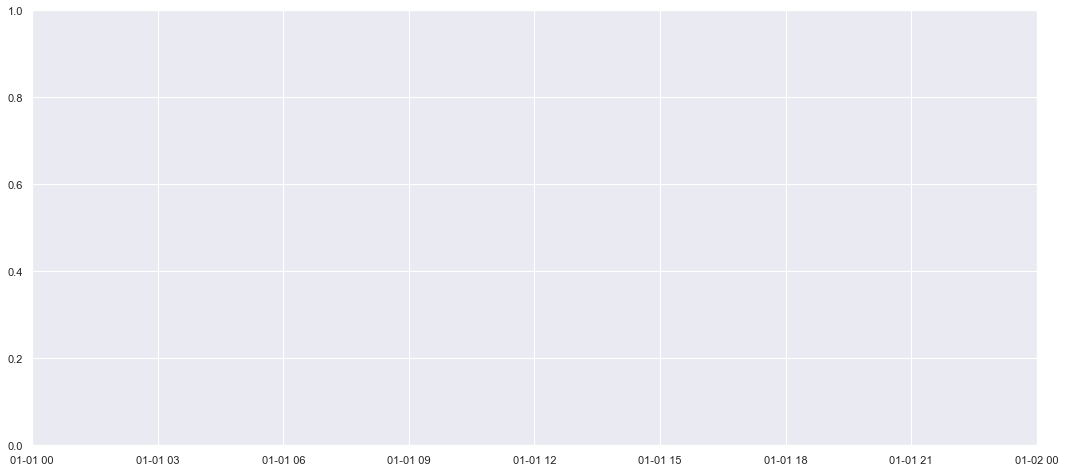

In [270]:
date_index =test_log_returns.index

plt.figure(figsize=(18,8))
plt.plot(date_index, forecasted_volatility, label='Forecasted Volatility', color='red', linestyle='dashed')
plt.plot(date_index, np.sqrt(test_log_returns), label='Actual Volatility', color='blue')  
plt.ylabel('Volatility')
plt.title('ARCH Model Forecasted vs. Actual Volatility')
plt.legend()
plt.show()

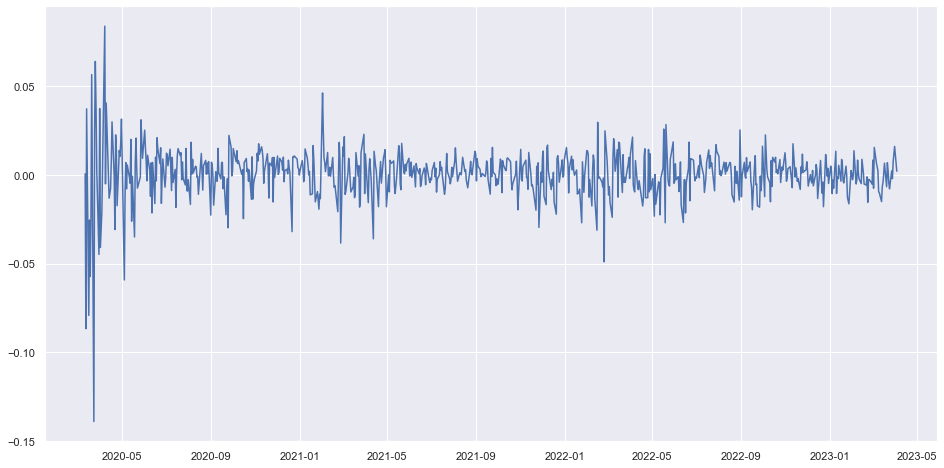

In [261]:
plt.plot(test_log_returns)

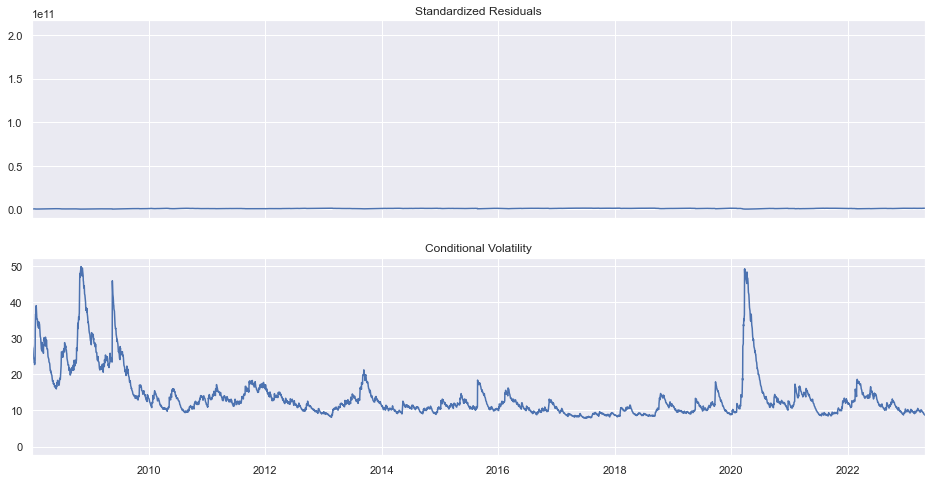

In [230]:
result.plot()
plt.show()

In [221]:
forecasts = result_1 .forecast(horizon=5, reindex=False)
print(forecasts.residual_variance.iloc[-3:])

                 h.1       h.2       h.3       h.4       h.5
Date                                                        
2020-03-09  0.001118  0.000558  0.000334  0.000244  0.000208


In [228]:
forecasts = result_1.forecast(horizon=5, reindex=False)
print(forecasts.variance.dropna().head())

                 h.1       h.2       h.3       h.4       h.5
Date                                                        
2020-03-09  0.001118  0.000558  0.000334  0.000244  0.000208
